In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

path = '/home/rbodo/.snntoolbox/data/imagenet/inception_lasagne/log/gui/test/spiketrains'
spiketrains_batch = np.load(os.path.join(path, '0.npz'))['spiketrains']
print("spiketrains_batch is list of tuples: [(layer0_spiketrains, layer0_name), ...]")
print("Shape of layer_spiketrains: (batch_size, feature-maps, width, height, timesteps)")
print("E.g. first layer: {}".format(spiketrains_batch[0][0].shape))
T = spiketrains_batch[0][0].shape[-1]  # Simulation time
epsilon = 1e-4  # Convergence measure
num_layers_to_plot = 20  # For memory and time reasons

In [14]:
spikerates = []
for layer in spiketrains_batch[:num_layers_to_plot]:
    print(layer[1])
    spiketrains = np.reshape(layer[0], (-1, layer[0].shape[-1]))
    spikerates_t = np.cumsum(np.greater(spiketrains, 0), axis=1) / np.arange(1, T + 1)
    spikerates.append((spikerates_t, layer[1]))

00Convolution2D_32x149x149


01Convolution2D_32x147x147


02Convolution2D_64x147x147


03MaxPooling2D_64x73x73


04Convolution2D_80x73x73


05Convolution2D_192x71x71


06MaxPooling2D_192x35x35


10Convolution2D_64x35x35
08Convolution2D_48x35x35


11Convolution2D_96x35x35
13AveragePooling2D_192x35x35


07Convolution2D_64x35x35
09Convolution2D_64x35x35


12Convolution2D_96x35x35
14Convolution2D_32x35x35


19Convolution2D_64x35x35
17Convolution2D_48x35x35


20Convolution2D_96x35x35
22AveragePooling2D_256x35x35


16Convolution2D_64x35x35


In [15]:
dt = 10  # Sliding window
variances = []
for layer in spikerates:
    spikerates_t = layer[0]
    variance_t = np.zeros((spikerates_t.shape[0], spikerates_t.shape[1] - dt))
    for t in range(spikerates_t.shape[-1] - dt):
        variance_t[:, t] = np.var(spikerates_t[:, t:t+dt], axis=1)
    variances.append((variance_t, layer[1]))

In [13]:
def plot_spikerates(spikerates):
    plt.title('Spike-rates')
    plt.xlabel('t')
    plt.ylabel('f')
    for spikerate_t in spikerates:
        plt.plot(spikerate_t)
    plt.savefig(os.path.join(path, 'spikerates'))


def plot_variances(variances, epsilon):
    plt.title('Variances')
    plt.xlabel('t')
    plt.ylabel('sigma')
    plt.semilogy(variances.transpose())
    plt.plot(np.arange(T), np.ones(T) * epsilon, '.', markersize=1.5)
    plt.savefig(os.path.join(path, 'variances'))


def plot_avg_var(variances, epsilon):
    plt.figure()
    plt.title('Average variances')
    plt.xlabel('t')
    plt.ylabel('sigma')
    for layer in variances:
        y = np.mean(layer[0], axis=0)
        plt.plot(y, label=layer[1][:6])
        std = np.std(layer[0], axis=0)
        plt.fill_between(np.arange(len(std)), y, y+std, alpha=0.05)
        plt.yscale('log', nonposy='clip')
    plt.plot(np.arange(T), np.ones(T) * epsilon, '.', label='Convergence', markersize=1.5)
    plt.ylim(0)
    plt.legend(prop={'size': 10})
    plt.savefig(os.path.join(path, 'avg_var'))


def plot_convergence_time(t_convergence, duration):
    plt.figure()
    plt.title('Spike-rate convergence time across layers')
    plt.xlabel('Layer index')
    plt.ylabel('Time of convergence')
    plt.plot([c[0] for c in t_convergence])
    plt.ylim(0, duration)
    plt.savefig(os.path.join(path, 't_convergence'))

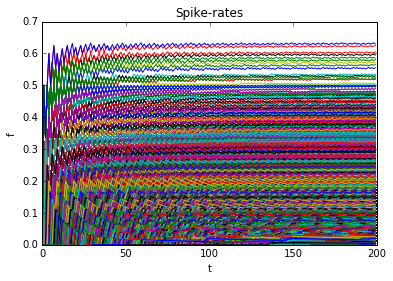

In [18]:
plot_spikerates(spikerates[0][0])

In [16]:
plot_variances(variances[0][0], epsilon)

In [17]:
plot_avg_var(variances, epsilon)

In [6]:
t_convergence = []
for layer in variances:
    avg_var = np.mean(layer[0], axis=0)
    t_convergence.append((np.min((avg_var < epsilon).nonzero()), layer[1]))

In [8]:
plot_convergence_time(t_convergence, T)

Problem with using variance as measure to determine when to stop clamping: Some variances may never fall below the threshold. Need to set a time threshold for those, or raise the threshold, which decreases performance for the others. Also, variances in high layers may initially be very small, e.g. in the absence of any input, so that no clamp is applied even though it would be needed. So we would have to apply another (time) threshold for those...?

In [1]:
var_t = np.loadtxt('/home/rbodo/.snntoolbox/data/imagenet/inception_averagepool/log/gui/clamp_var/var_t.txt', delimiter=',')

In [6]:
import os
T = 100
epsilon = 1e-4
path = '/home/rbodo/Downloads'
plt.title('Variances')
plt.xlabel('t')
plt.ylabel('sigma')
plt.semilogy(var_t)
plt.plot(np.arange(T), np.ones(T) * epsilon, '.', markersize=1.5)
plt.savefig(os.path.join(path, 'all_var_t'))